In [ ]:
import torch
import os
import numpy as np
import random
import timeit
import torchvision
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from diffusers import DDIMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from utils import CustomImageLabelDataset, mean_std, split_dataset, label_normalizer
from unet import ConditionalUNet

In [30]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [31]:
RANDOM_SEED = 0
IMG_SIZE = 128
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
NUM_EPOCHS = 50
NUM_TIMESTEPS = 1000
NUM_WARMUP_STEPS = 500
PATIENCE = 10
LAMBDA_1 = 0.2  # MSE - student and teacher
LAMBDA_2 = 0.8  # MSE - student and real

max_power = 200.
min_power = 100.
max_scan_speed = 0.75
min_scan_speed = 0.25

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [32]:
image_folder = '/Users/xiezy/Documents/ml/diffusion/data/long_sec/train_exp/train/images'
label_folder = '/Users/xiezy/Documents/ml/diffusion/data/long_sec/train_exp/train/labels'

In [33]:
transform0 = transforms.Compose([
    transforms.Resize((128, 128),  # reshape to (128, 128), interpolation: nearest
                      interpolation=transforms.InterpolationMode.NEAREST), 
    transforms.ToTensor()  # rescale: from 0-255 to 0-1
])

dataset = CustomImageLabelDataset(image_folder=image_folder, label_folder=label_folder, transform=transform0)
mean, std = mean_std(dataset)

print(f'mean and std of the dataset are: {mean, std}')

# mean, std = [0.5], [0.5]

mean and std of the dataset are: ([0.6598671674728394, 0.6139081716537476, 0.60301673412323], [0.3276596665382385, 0.35919493436813354, 0.31930240988731384])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8394176..1.243283].


Train dataset size: 800
Validation dataset size: 200
Input shape: torch.Size([16, 3, 128, 128])
Labels: tensor([[200.0000,   0.2500],
        [200.0000,   0.2500],
        [200.0000,   0.2500],
        [200.0000,   0.2500],
        [200.0000,   0.2500],
        [200.0000,   0.7500],
        [200.0000,   0.2500],
        [200.0000,   0.7500],
        [200.0000,   0.7500],
        [200.0000,   0.2500],
        [200.0000,   0.7500],
        [200.0000,   0.2500],
        [200.0000,   0.7500],
        [200.0000,   0.7500],
        [200.0000,   0.7500],
        [200.0000,   0.2500]])


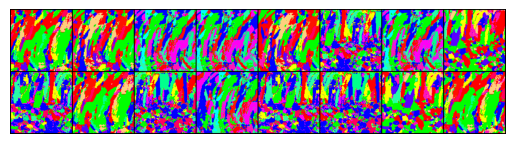

In [34]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.NEAREST), 
    transforms.ToTensor(), 
    transforms.Normalize(mean, std)  # normalize by the mean and std 
])

dataset = CustomImageLabelDataset(image_folder=image_folder, label_folder=label_folder, transform=transform)

dataset_size = len(dataset)
train_indices, val_indices = split_dataset(dataset_size, val_ratio=0.2)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")

x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
grid_img = torchvision.utils.make_grid(x)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

In [35]:
T_model = ConditionalUNet()
file_dir = '/bohr/rf2-1r14/v3'
file_name = 'simu_main_gau.pth'
os.makedirs(file_dir, exist_ok=True)
file_path = os.path.join(file_dir, file_name)

T_model.load_state_dict(torch.load(file_path, map_location=device, weights_only=True))
T_model.eval()
T_model.to(device)

OSError: [Errno 30] Read-only file system: '/bohr'

In [ ]:
S_model = ConditionalUNet()
# S_model.model = UNet2DModel(
#             sample_size=None,
#             in_channels=3,
#             out_channels=3,
#             time_embedding_dim=128,
#             layers_per_block=2,
#             block_out_channels=(32, 128, 512),
#             down_block_types=(
#                 "DownBlock2D",
#                 "DownBlock2D",
#                 "DownBlock2D"
#             ),
#             up_block_types=(
#                 "UpBlock2D",
#                 "UpBlock2D",
#                 "UpBlock2D"
#             ),
#         )
S_model.condition_embedding.W = T_model.condition_embedding.W
S_model.train()
S_model.to(device)

In [ ]:
# Create a scheduler
noise_scheduler = DDIMScheduler(num_train_timesteps=NUM_TIMESTEPS)

In [ ]:
LAMBDA_1 = 0.2  # 权重：学生和教师模型生成图片之间的 MSE
LAMBDA_2 = 0.8  # 权重：学生模型和真实图片之间的 MSE

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, S_model.parameters()), lr=LEARNING_RATE) # weight_decay=None

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=NUM_WARMUP_STEPS,
    num_training_steps=len(train_dataloader) * NUM_EPOCHS
)

early_stopping_patience = PATIENCE
best_val_loss = float('inf') 
patience_counter = 0

losses = []
val_losses = []

start = timeit.default_timer()
print(f'Everything is ready.\nTraining start time: {start:.2f}s')

for epoch in tqdm(range(NUM_EPOCHS), position=0, leave=True):
    # traning
    S_model.train()
    train_running_loss = 0
    for x, y in train_dataloader:
        clean_images = x.to(device)
        noise = torch.randn(clean_images.shape).to(device)
        last_batch_size = len(clean_images)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        power, scan_speed = y[:, 0], y[:, 1]
        power = label_normalizer(power, max_power, min_power).to(device)
        scan_speed = label_normalizer(scan_speed, max_scan_speed, min_scan_speed).to(device)

        # Predict noise with teacher model
        with torch.no_grad():
            teacher_noise = T_model(noisy_images, timesteps, power, scan_speed)

        # Predict noise with student model
        student_noise = S_model(noisy_images, timesteps, power, scan_speed)

        loss_teacher = F.mse_loss(student_noise, teacher_noise)  # student-teacher MSE
        loss_real = F.mse_loss(student_noise, noise)  # student-real MSE
        loss = LAMBDA_1 * loss_teacher + LAMBDA_2 * loss_real
        train_running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(S_model.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
    
    avg_train_loss = train_running_loss / len(train_dataloader)
    losses.append(avg_train_loss)
    train_learning_rate = lr_scheduler.get_last_lr()[0]

    # validation
    S_model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for x, y in val_dataloader:
            clean_images = x.to(device)
            noise = torch.randn(clean_images.shape).to(device)
            last_batch_size = len(clean_images)
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (last_batch_size,)).to(device)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            power, scan_speed = y[:, 0], y[:, 1]
            power = label_normalizer(power, max_power, min_power).to(device)
            scan_speed = label_normalizer(scan_speed, max_scan_speed, min_scan_speed).to(device)

            # Predict noise with teacher model
            teacher_noise = T_model(noisy_images, timesteps, power, scan_speed)

            # Predict noise with student model
            student_noise = S_model(noisy_images, timesteps, power, scan_speed)

            val_loss_teacher = F.mse_loss(student_noise, teacher_noise)  # 学生-教师 MSE
            val_loss_real = F.mse_loss(student_noise, noise)  # 学生-真实图片 MSE
            val_loss = LAMBDA_1 * loss_teacher + LAMBDA_2 * loss_real
            val_running_loss += val_loss.item()
    
    avg_val_loss = val_running_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print('-' * 50)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print(f'Train Learning Rate: {epoch + 1}: {train_learning_rate}')
    print(f"Training Loss: {avg_train_loss:.6f}")
    print(f"Validation Loss: {avg_val_loss:.6f}")
    print('-' * 50)

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(S_model.state_dict(), mdl_path)
        print("Best model saved.")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve for {patience_counter} epoch(s).")
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered.")
            break

end = timeit.default_timer()
print(f'Training finish time: {end:.2f}s')
print(f'Total training time: {end - start:.2f}s')

plt.figure()
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(cht_path) 
plt.close()
print(f"Loss chart saved.")

NameError: name 'train_dataloader' is not defined

# EVA

In [38]:
S_model = ConditionalUNet()
file_dir = '/Users/xiezy/Documents/ml/diffusion/model_save'
file_name = 'l_dis_l28.pth'
os.makedirs(file_dir, exist_ok=True)
file_path = os.path.join(file_dir, file_name)

S_model.load_state_dict(torch.load(file_path, map_location=device, weights_only=True))
S_model.eval()
S_model.to(device)

ConditionalUNet(
  (condition_embedding): RFFEmbedder()
  (model): UNet2DModel(
    (conv_in): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (time_proj): Timesteps()
    (time_embedding): TimestepEmbedding(
      (linear_1): Linear(in_features=32, out_features=128, bias=True)
      (act): SiLU()
      (linear_2): Linear(in_features=128, out_features=128, bias=True)
    )
    (down_blocks): ModuleList(
      (0): DownBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
            (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
            (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )


tensor([1.], device='mps:0') tensor([0.5000], device='mps:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44824103..0.32591015].


<class 'torch.Tensor'>
torch.Size([1, 3, 128, 128])
tensor([-0.0047,  0.0284,  0.0196])
tensor([0.0752, 0.0667, 0.1081])
tensor(0.3259)


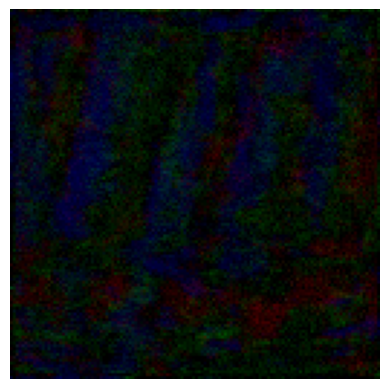

In [43]:
# generate random noise
noise_scheduler = DDIMScheduler(num_train_timesteps=NUM_TIMESTEPS)
# torch.manual_seed(42)
noise_scheduler.set_timesteps(num_inference_steps=20)

num_images = 1

x = torch.randn(num_images, 3, 128, 128).to(device)

power = torch.full((num_images, ), 200)
scan_speed = torch.full((num_images, ), 0.5)
# scan_speed = torch.tensor([0.75, 0.5, 0.25])
power = label_normalizer(power, max_power, min_power).to(device)
scan_speed = label_normalizer(scan_speed, max_scan_speed, min_scan_speed).to(device)
print(power, scan_speed)

for i, t in enumerate(noise_scheduler.timesteps):
    with torch.no_grad():
        residual = S_model(x, t, power, scan_speed)

    x = noise_scheduler.step(residual, t, x).prev_sample

for i, t in enumerate(noise_scheduler.timesteps[-2:]):
    with torch.no_grad():
        residual = S_model(x, t, power, scan_speed)

    x = noise_scheduler.step(residual, t, x).prev_sample

x = x.detach().cpu()
print(type(x))
print(x.shape)
print(x.mean(dim=(0, 2, 3)))
print(x.std(dim=(0, 2, 3)))
print(torch.max(x))

grid_img = torchvision.utils.make_grid(x)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()

torch.Size([1, 3, 128, 128])
mean: tensor([0.6583, 0.6241, 0.6093])
std: tensor([0.0246, 0.0240, 0.0345])
max: 0.7666547894477844
min: 0.45989227294921875


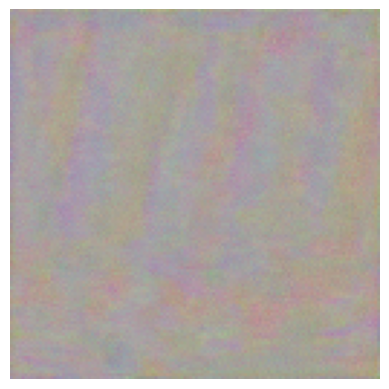

: 

In [ ]:
def img_denormalizer(batch, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1)
    std = torch.tensor(std).view(1, 3, 1, 1)  
    denormalized_batch = batch * std + mean

    return denormalized_batch


denormalized_batch = img_denormalizer(x, mean, std)
print(denormalized_batch.shape)
print(f"mean: {denormalized_batch.mean(dim=(0, 2, 3))}\n"
      f"std: {denormalized_batch.std(dim=(0, 2, 3))}\n"
      f"max: {denormalized_batch.max()}\n"
      f"min: {denormalized_batch.min()}")

grid_img = torchvision.utils.make_grid(denormalized_batch)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')

plt.savefig('../data/long_sec/gen_images/dis/dis_b55.jpg', bbox_inches='tight', pad_inches=0, dpi=300)


# sample_img_1 = denormalized_batch.clamp(0, 1)
# sample_img_255 = (sample_img_1 * 255).byte().permute(0, 2, 3, 1)

# print(sample_img_255.shape)

# resize_transform = transforms.Resize((474, 474), interpolation=transforms.InterpolationMode.NEAREST)

# resized_imgs = []
# for i in range(sample_img_255.shape[0]):
#     pil_img = Image.fromarray(np.array(sample_img_255[i]))
#     resized_img = resize_transform(pil_img)
#     resized_imgs.append(resized_img)

# resized_imgs_np = np.array(resized_imgs)
# print(resized_imgs_np.shape)


# batch_size = resized_imgs_np.shape[0]
# ncols = 1
# nrows = (batch_size + ncols - 1) // ncols

# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5 * nrows))

# if nrows == 1 or ncols == 1:
#     axes = np.array(axes).reshape(nrows, ncols)

# for i in range(batch_size):
#     ax = axes[i // ncols, i % ncols]
#     ax.imshow(resized_imgs_np[i])
#     ax.axis('off')

# for j in range(batch_size, nrows * ncols):
#     axes[j // ncols, j % ncols].axis('off')

# plt.tight_layout()
# plt.show()